In [1]:
import os
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import CenterCrop
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import PIL

2022-12-20 07:17:32.711481: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
tf.__version__

'2.9.1'

## Examine Image Sizes

In [3]:
image_dir = 'images/'
files = os.listdir(image_dir)
images = [f for f in files if re.search(r'.jpg$', f)]

sizes = []

for image in images:
    img = PIL.Image.open(f'{image_dir}/{image}')
    sizes.append(img.size)

In [4]:
sizes_df = pd.DataFrame({'img_size':sizes})
sizes_df.value_counts(ascending=False)

img_size   
(750, 1000)    6505
(1000, 750)     552
(562, 1000)     518
(450, 1000)     290
(753, 1000)     196
               ... 
(746, 690)        1
(625, 1000)       1
(619, 1000)       1
(612, 408)        1
(656, 468)        1
Length: 64, dtype: int64

## Get Training Dataset

Note, `dataset_generator.ipynb` creates correct directory structure

In [5]:
img_size = (256, 256)

dataset = keras.preprocessing.image_dataset_from_directory(
    'images_by_class/train/',
    batch_size=None, 
    image_size=img_size
)

Found 5559 files belonging to 6 classes.


2022-12-18 02:09:51.894182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 02:09:51.908792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 02:09:51.909577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 02:09:51.910733: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

## Look at image data

In [5]:
for image, label in dataset.take(3):
    print(image.shape)  # (64, 200, 200, 3)
    print(image[0,0,])
    print(image.dtype)  # float32
    print(label.shape)  # (64,)
    print(label)
    print(label.dtype)  # int32

(256, 256, 3)
tf.Tensor([147.91211 101.91211  49.91211], shape=(3,), dtype=float32)
<dtype: 'float32'>
()
tf.Tensor(5, shape=(), dtype=int32)
<dtype: 'int32'>
(256, 256, 3)
tf.Tensor([165.52765 173.52765 175.52765], shape=(3,), dtype=float32)
<dtype: 'float32'>
()
tf.Tensor(2, shape=(), dtype=int32)
<dtype: 'int32'>
(256, 256, 3)
tf.Tensor([201.83234 202.92609 200.37921], shape=(3,), dtype=float32)
<dtype: 'float32'>
()
tf.Tensor(1, shape=(), dtype=int32)
<dtype: 'int32'>


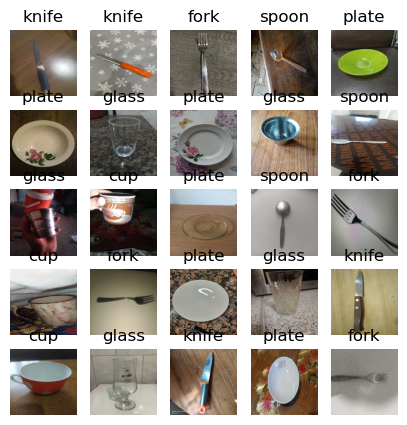

In [6]:
dataset_iterator = dataset.as_numpy_iterator()

plt.figure(figsize=(5, 5))
class_names = dataset.class_names

for i in range(25):
    image, label = next(dataset_iterator)
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")


### Ensure RGB values valid

In [7]:
dataset_iterator = dataset.as_numpy_iterator()

rgb_min = None
rgb_max = None

for img, lbl in dataset_iterator:
    flat = img.flatten()

    flat_min = np.min(flat)
    flat_max = np.max(flat)

    if not rgb_min:
        rgb_min = flat_min
    else:
        rgb_min = np.min([flat_min, rgb_min])

    if not rgb_max:
        rgb_max = flat_max
    else:
        rgb_max = np.max([flat_max, rgb_max])

        
print([rgb_min, rgb_max])

[1.2019653, 255.0]


## Keras Tutorial Model

In [8]:
# https://keras.io/examples/vision/image_classification_from_scratch/
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "images_by_class/train/",
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "images_by_class/train/",
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5559 files belonging to 6 classes.
Using 4448 files for training.
Found 5559 files belonging to 6 classes.
Using 1111 files for validation.


In [9]:
# following along with keras tutorial
# https://www.tensorflow.org/tutorials/images/classification

img_height = img_size[0]
img_width = img_size[1]
num_classes = len(class_names)

model = Sequential([
    keras.Input(shape=(img_height, img_width, 3)),
    
    layers.CenterCrop(height=img_height, width=img_width),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dense(128, activation='relu'),
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(num_classes, activation="softmax")
])

In [11]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [12]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/10


2022-12-17 05:03:13.619709: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-17 05:03:14.269942: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 05:03:14.270953: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 05:03:14.270993: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-17 05:03:14.272270: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 05:03:14.272359: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


139/139 [==============================] - 16s 89ms/step - loss: 1.7685 - accuracy: 0.2172 - val_loss: 1.7622 - val_accuracy: 0.2115
Epoch 2/10
139/139 [==============================] - 12s 85ms/step - loss: 1.7639 - accuracy: 0.2221 - val_loss: 1.7604 - val_accuracy: 0.2115
Epoch 3/10
139/139 [==============================] - 14s 97ms/step - loss: 1.7637 - accuracy: 0.2230 - val_loss: 1.7608 - val_accuracy: 0.2115
Epoch 4/10
139/139 [==============================] - 14s 97ms/step - loss: 1.7638 - accuracy: 0.2230 - val_loss: 1.7611 - val_accuracy: 0.2115
Epoch 5/10
139/139 [==============================] - 12s 84ms/step - loss: 1.7628 - accuracy: 0.2230 - val_loss: 1.7604 - val_accuracy: 0.2115
Epoch 6/10
139/139 [==============================] - 12s 84ms/step - loss: 1.7621 - accuracy: 0.2230 - val_loss: 1.7603 - val_accuracy: 0.2115
Epoch 7/10
139/139 [==============================] - 12s 85ms/step - loss: 1.7619 - accuracy: 0.2230 - val_loss: 1.7602 - val_accuracy: 0.2115
Epo

In [13]:
def get_val_accuracy_delta(history):
    val_accuracy_start = history.history['val_accuracy'][0]
    val_accuracy_end = history.history['val_accuracy'][-1]
    
    return (val_accuracy_end - val_accuracy_start)

model_val_delta = get_val_accuracy_delta(history)

print(f'Change in validation accuracy: {model_val_delta:.3f}')

Change in validation accuracy: 0.000


Not a great model

### Transfer learning with Xception

We'll start with the Xception base model and add an additional dense layer on top of it

In [53]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False # Do not include the ImageNet classifier at the top.
)

base_model.trainable = False

inputs = keras.Input(shape=(img_height, img_width, 3))

x = tf.cast(inputs, tf.float32)
x = keras.applications.xception.preprocess_input(x)
x = base_model(inputs, training=False)
x = layers.MaxPooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model_x = keras.Model(inputs, outputs)

learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy()

model_x.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

In [54]:
epochs = 10

history_x = model_x.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/10
139/139 [==============================] - 30s 197ms/step - loss: 19.7208 - accuracy: 0.2902 - val_loss: 1.6234 - val_accuracy: 0.3276
Epoch 2/10
139/139 [==============================] - 28s 196ms/step - loss: 1.5845 - accuracy: 0.3482 - val_loss: 1.5727 - val_accuracy: 0.3474
Epoch 3/10
139/139 [==============================] - 28s 200ms/step - loss: 1.5393 - accuracy: 0.3588 - val_loss: 1.5249 - val_accuracy: 0.3699
Epoch 4/10
139/139 [==============================] - 29s 203ms/step - loss: 1.4805 - accuracy: 0.3835 - val_loss: 1.4908 - val_accuracy: 0.3627
Epoch 5/10
139/139 [==============================] - 29s 206ms/step - loss: 1.4238 - accuracy: 0.4033 - val_loss: 1.4441 - val_accuracy: 0.3924
Epoch 6/10
139/139 [==============================] - 29s 208ms/step - loss: 1.3674 - accuracy: 0.4150 - val_loss: 1.4230 - val_accuracy: 0.4032
Epoch 7/10
139/139 [==============================] - 30s 211ms/step - loss: 1.3011 - accuracy: 0.4375 - val_loss: 1.4281 - val_a

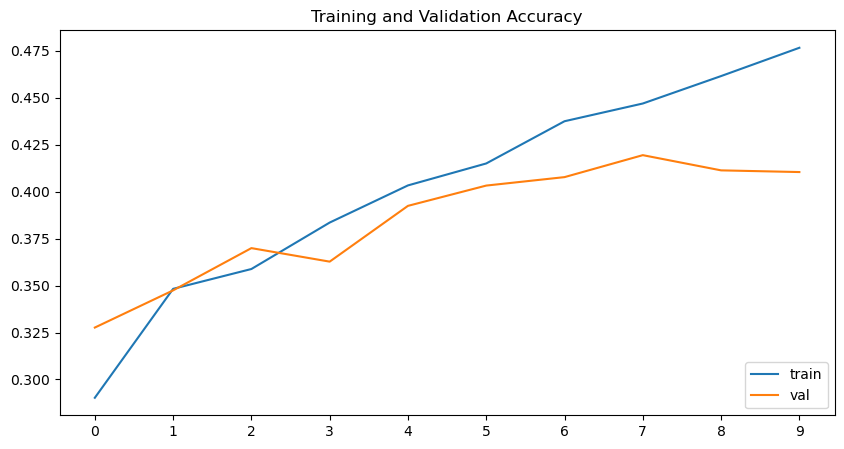

In [55]:
acc = history_x.history['accuracy']
val_acc = history_x.history['val_accuracy']

plt.plot(acc, label='train')
plt.plot(val_acc, label='val')
plt.xticks(np.arange(epochs))
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

Much improvement here, but generally looks like we're overfitting as training accuracy continues to rise as validation accuracy flattens out. We'll continue on to explore a better learning rate.

### Adjust the learning rate

In [57]:
def make_model(learning_rate=0.01):
    
    base_model = keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(img_height, img_width, 3),
        include_top=False # Do not include the ImageNet classifier at the top.
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(img_height, img_width, 3))

    x = tf.cast(inputs, tf.float32)
    x = keras.applications.xception.preprocess_input(x)
    x = base_model(inputs, training=False)
    x = layers.MaxPooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    learning_rate = learning_rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [58]:
scores = {}
epochs = 10

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        batch_size=32,
        epochs=epochs
    )
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
139/139 [==============================] - 56s 191ms/step - loss: 10.4595 - accuracy: 0.2743 - val_loss: 4.3412 - val_accuracy: 0.3348
Epoch 2/10
139/139 [==============================] - 26s 186ms/step - loss: 3.9669 - accuracy: 0.3433 - val_loss: 3.4345 - val_accuracy: 0.3573
Epoch 3/10
139/139 [==============================] - 26s 186ms/step - loss: 3.0439 - accuracy: 0.3887 - val_loss: 2.8717 - val_accuracy: 0.4086
Epoch 4/10
139/139 [==============================] - 26s 187ms/step - loss: 2.5197 - accuracy: 0.4236 - val_loss: 2.7055 - val_accuracy: 0.4041
Epoch 5/10
139/139 [==============================] - 26s 186ms/step - loss: 2.2151 - accuracy: 0.4550 - val_loss: 2.5038 - val_accuracy: 0.4248
Epoch 6/10
139/139 [==============================] - 26s 187ms/step - loss: 1.9739 - accuracy: 0.4798 - val_loss: 2.4092 - val_accuracy: 0.4347
Epoch 7/10
139/139 [==============================] - 27s 188ms/step - loss: 1.8202 - accuracy: 0.5054 - val_loss: 2.2440 

Text(0.5, 1.0, 'Validation Accuracy by Learning Rate')

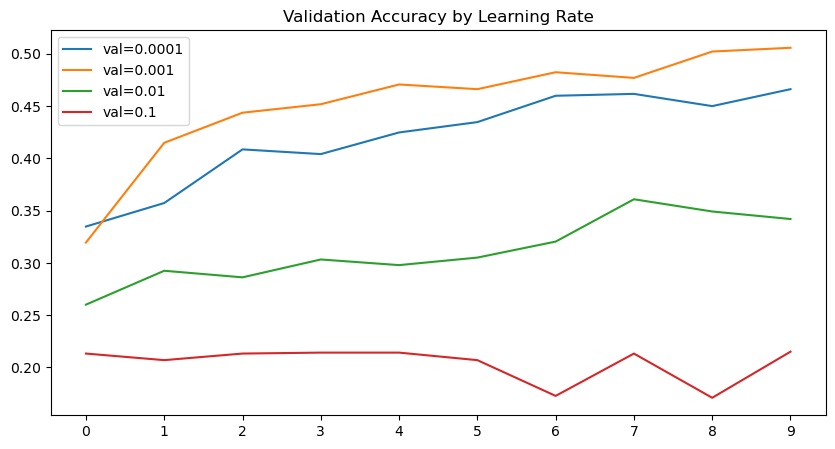

In [60]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()
plt.title('Validation Accuracy by Learning Rate')

Pretty clearly `0.001` is our best learning rate, it's encouraging that performance continued to rise with epochs.

Text(0.5, 1.0, 'Learning rate:0.001, val & train accuracy')

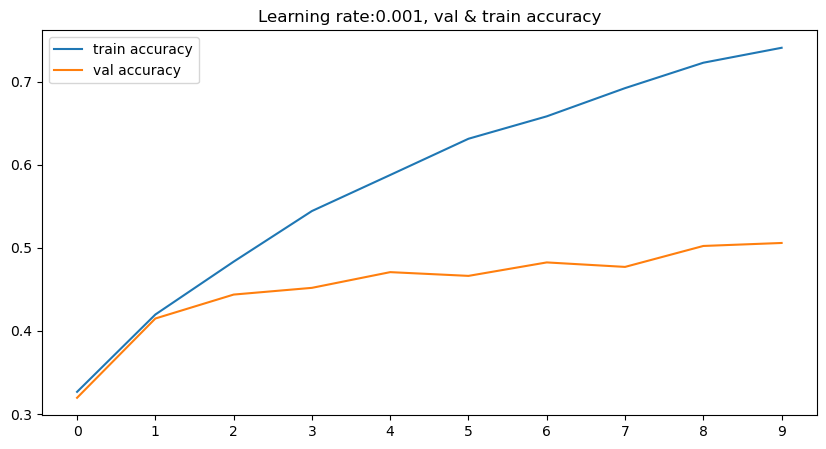

In [62]:
lr = 0.001
plt.plot(scores[lr]['accuracy'], label='train accuracy')
plt.plot(scores[lr]['val_accuracy'], label='val accuracy')

plt.xticks(np.arange(10))
plt.legend()
plt.title(f'Learning rate:{lr}, val & train accuracy')